# ResNet18 on MNIST – Companion Notebook for Chapter 4

This notebook accompanies **Chapter 4 (Neural Networks)**, expanding on the ResNet discussion by moving from a lightweight ResNet9-style architecture to a **deeper ResNet18**-type model.

It allows you to:
- Compare depth and capacity effects on MNIST classification.
- Observe how optimization dynamics (training curves, convergence speed) change with deeper residual networks.
- Connect the architectural discussion of **deep residual networks** to empirical behavior on a standard benchmark.

As with other companion notebooks, this is an **optional** computational exploration that complements, but does not replace, the mathematical development in the chapter.


/Users/chertkov/.julia/conda/3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/chertkov/.julia/conda/3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/10], Loss: 0.1033
Epoch [2/10], Loss: 0.0456
Epoch [3/10], Loss: 0.0342
Epoch [4/10], Loss: 0.0274
Epoch [5/10], Loss: 0.0229
Epoch [6/10], Loss: 0.0205
Epoch [7/10], Loss: 0.0161
Epoch [8/10], Loss: 0.0150
Epoch [9/10], Loss: 0.0144
Epoch [10/10], Loss: 0.0131


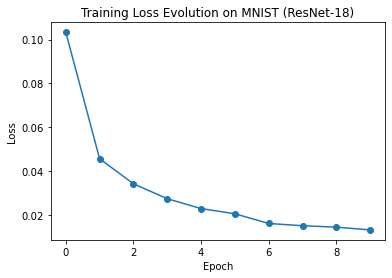

Test Accuracy: 99.21%


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


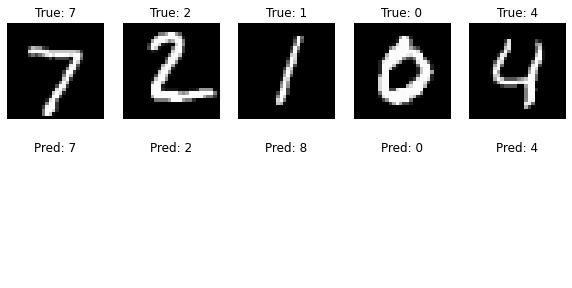

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(0)

# Define transformations for MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize MNIST images
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define a ResNet-18 model adapted for MNIST
class ResNet18MNIST(nn.Module):
    def __init__(self):
        super(ResNet18MNIST, self).__init__()
        self.resnet = models.resnet18(pretrained=False)  # Load standard ResNet-18
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adapt for grayscale
        self.resnet.fc = nn.Linear(512, 10)  # Modify final layer for 10 MNIST classes

    def forward(self, x):
        return self.resnet(x)

# Initialize model, loss function, and optimizer
model = ResNet18MNIST()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# Plot training loss evolution
plt.figure(figsize=(6, 4))
plt.plot(loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Evolution on MNIST (ResNet-18)")
plt.show()

# Evaluate on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# Visualize test classification results
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    sample_image, sample_label = test_dataset[i]
    sample_image = sample_image.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(sample_image)
        predicted_label = torch.argmax(output, dim=1).item()

    axes[0, i].imshow(sample_image.squeeze(0).squeeze(0), cmap="gray")
    axes[0, i].set_title(f"True: {sample_label}")
    axes[1, i].set_title(f"Pred: {predicted_label}")

for ax in axes.flat:
    ax.axis("off")

plt.show()